# Analyzing Thomas Fire in Santa Barbara County
### EDS220, Fall2023

### Author 
- Haejin Kim, UC Santa Barbara (haejin_kim@bren.ucsb.edu)

### Github repository
https://github.com/khj9759/eds220-task3.git

## Purpose
You'll utilize Air Quality Index (AQI) data provided by the US Environmental Protection Agency to visually represent the influence of the 2017-2018 Thomas Fire in Santa Barbara County. Your objective is to generate a false-color image that vividly illustrates the extent of the fire scar left by the Thomas Fire in 2017.

## Highlights of analysis 
- Data wrangling and exploration with `pandas`
- Geospatial data wrangling with `geopandas`
- time series analysis
- visualize raster data 
- dissolve the district data 
- patch function for creating legend

## Dataset Description
### Air Quality Index (AQI) Data

Two datasets, namely aqi_17 and aqi_18, represent the Daily AQI by County and Daily AQI by Core-Based Statistical Area (CBSA) for the respective years 2017 and 2018.
Data Source:
- aqi_17: https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip
- aqi_18: https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip
### Landsat Collection 2 Level-2 Surface Reflectance Data

A simplified compilation of bands including red, green, blue, near-infrared, and shortwave infrared, sourced from the Landsat Collection 2 Level-2 atmospherically corrected surface reflectance data. These bands were captured by the Landsat 8 satellite.
Data Location: Saved within the landsat folder.
### California Fire Perimeters (2017) Shapefile

A shapefile depicting fire perimeters within California specifically during the year 2017.
Data Location: Saved within the ca_fire folder in the dataset.
These datasets collectively provide information on air quality indices, Landsat satellite-derived bands, and the shapefile of fire perimeters during 2017, offering crucial insights for analyzing the impact of events like the Thomas Fire on environmental quality and landscape dynamics.

## Reference
- Air Quality Index (AQI) calculations: https://www.airnow.gov/aqi/aqi-basics/
- US Environmental Protection Agency (EPA): https://www.epa.gov
- Thomas Fire: https://en.wikipedia.org/wiki/Thomas_Fire
- 2017 Fire Season: https://www.fire.ca.gov/incidents/2017/
- 2020 Fire Season: https://www.fire.ca.gov/incidents/2020/
- NASA Earth Observatory: https://earthobservatory.nasa.gov/features/FalseColor

## Import package

In [1]:
# library 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends

import xarray as xr
import rioxarray as rioxr
import geopandas as gpd

from rasterio.features import rasterize # for rasterizing polygons

pd.set_option('display.max_columns', None)

## Import data
### data of the AQI in 2017 and 2018 and clean up 

In [2]:
# data of the AQI in 2017 and 2018  
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")
aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")

# combine 2017 and 2018 dataset 
aqi = pd.concat([aqi_17, aqi_18], ignore_index=True)

# makes them lower case to clean this: 
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')

# check the dataframe of the AQI
aqi.head(3)

,state_name,county_name,state_code,county_code,date,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,19,Good,PM2.5,01-003-0010,1


### data of landsat and california fire data 

In [3]:
# open landsat and california fire data 
landsat = rioxr.open_rasterio('data/landsat8-2018-01-26-sb-simplified.nc')
ca_fire = gpd.read_file(os.path.join(os.getcwd(), 'data','California_Fire_Perimeters_2017','California_Fire_Perimeters_2017.shp'))

## clean up the dataset 
ca_fire.columns = ca_fire.columns.str.lower()
ca_fire = ca_fire.to_crs(landsat.rio.crs)

# review the california fire data
ca_fire.head(3)

,index,objectid,year_,state,agency,unit_id,fire_name,inc_num,alarm_date,cont_date,cause,c_method,objective,gis_acres,comments,complex_na,complex_in,irwinid,fire_num,decades,shape_leng,shape_area,geometry
0,19836,41429,2017,CA,CCO,VNC,BROOK,00042450,2017-05-23,2017-05-24,14.0,1.0,1.0,10.043819,per walked track,None,None,None,None,2010,1246.055781,59473.666651,"POLYGON ((329836.442 3778607.342, 329858.049 3..."
1,19837,41430,2017,CA,CCO,VNC,PACIFIC,00075307,2017-09-09,2017-09-09,14.0,1.0,1.0,1.190109,Final Walked track. Small spot to the north east,None,None,None,None,2010,561.418202,7081.369481,"POLYGON ((283091.321 3802354.285, 283072.171 3..."
2,19838,41431,2017,CA,CCO,VNC,GRADE,00054660,2017-07-04,2017-07-05,14.0,6.0,1.0,47.194027,None,None,None,None,None,2010,2587.259697,279911.825212,"POLYGON ((317706.428 3786632.044, 317720.407 3..."


## Geographical context of Data 

This dataset is limited to Santa Barbara County and focuses on identifying the scale of the fire and the Air Quality Index (AQI) concerning the Thomas Fire.

### Data selection of AQI 
This dataset encompasses the entire US states, but it has been filtered specifically to include Santa Barbara County in California. Unnecessary columns from other regions have been removed, retaining only the relevant information.

In [4]:
# select the califronia, santa barbara 
aqi_sb = aqi[(aqi.state_name == 'California') & (aqi.county_name == 'Santa Barbara')].copy()

# remove the not necessary columns
aqi_sb = aqi_sb.drop(columns = ['state_name','county_name','state_code','county_code'])

### Data to convert the timedate object 
to use the `to_dateimte`, and `set_index`, clean up the overall dataset

In [5]:
# covert precip.DATE column to timedate objects
aqi_sb.date = pd.to_datetime(aqi_sb.date)
aqi_sb = aqi_sb.set_index('date')

# Check the updated index of aqi_sb and its data type
index_dtype = aqi_sb.index

# check the final result
aqi_sb.head(3)

,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
date,,,,,
2017-01-01,39,Good,Ozone,06-083-4003,12
2017-01-02,36,Good,Ozone,06-083-4003,11
2017-01-03,71,Moderate,PM10,06-083-4003,12


### 5-day rolling mean of AQI 

In [6]:
# Calculate the 5-day rolling mean of AQI and add it as a new column
aqi_sb['five_day_average']=aqi_sb.aqi.rolling('5D').mean()

### Matching the CRS of the Fire Area and Satellite Image in California
This process involves aligning the Coordinate Reference System (CRS) of two datasets:

`ca_fire`: Shapefile representing fire area information.
`landsat`: Surface reflection data obtained from satellite imagery.

In [7]:
# check CRS
print(f"california_fire: {ca_fire.crs} \nland sat: {landsat.rio.crs}\n")

# transform fishing_areas CRS to epsg:32611
ca_fire = ca_fire.to_crs(landsat.rio.crs)

print('match crs landsat and ca_fire?:', landsat.rio.crs == ca_fire.crs)

california_fire: PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]] 
land sat: EPSG:32611

match crs landsat and ca_fire?: True


### clean up the band 
This is remove length 1 demension and coordinate associated to band

In [8]:
# original dimensions and coordinates
print(landsat.dims, landsat.coords,'\n')

# remove length 1 dimension (band)
landsat = landsat.squeeze()
print(landsat.dims, landsat.coords,'\n')

# remove coordinates associated to band
landsat = landsat.drop('band')
print(landsat.dims, landsat.coords)

Frozen({'y': 731, 'x': 870, 'band': 1}) Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0 

Frozen({'y': 731, 'x': 870}) Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    band         int64 1
    spatial_ref  int64 0 

Frozen({'y': 731, 'x': 870}) Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    spatial_ref  int64 0


### Dissolve by district as fire name 
check the number of district and rows and dissolve by district, and then clipping the CA parimeter only fire

In [9]:
# check number of districts and rows
print(f"number of geometries: {len(ca_fire)}")
print(f"number of districts: {len(ca_fire.fire_name.unique())}")

# dissolve by district
fire_districts = ca_fire[['geometry','fire_name']].dissolve(by='fire_name', as_index=False)

# clipping the ca perimeter only fire 
fire_districts_clip = landsat.rio.clip_box(*fire_districts.total_bounds)

number of geometries: 608
number of districts: 521


### Selecting the Fire Named "Thomas" 
Identify and filter the fire incidents specifically labeled as "Thomas" within the fire_name column, then organize the dataset to focus solely on the Thomas fire incidents.

In [10]:
# Registration areas:
# print(ca_fire.fire_name.unique())
fire_thomas = fire_districts[fire_districts.fire_name == 'THOMAS']

## Final Output
This visualization represents the 5-day average of the Air Quality Index (AQI) specifically for Santa Barbara County during the period of 2017 to 2018. The data showcases both the daily AQI readings and the 5-day average AQI, highlighting a significant peak in December 2017.

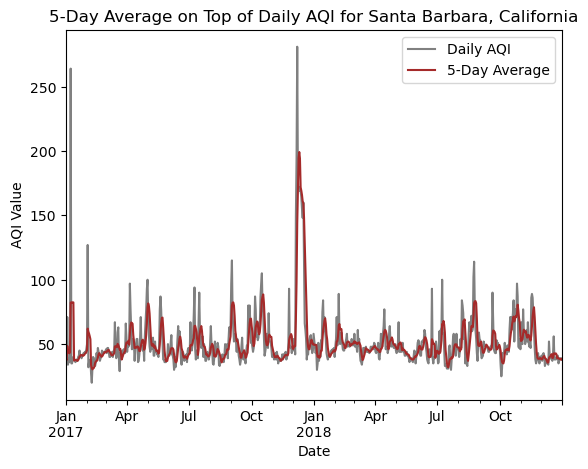

In [11]:
# initialize empty figure
fig, ax = plt.subplots()

# Create a line plot for daily AQI on the existing ax
aqi_sb.plot(y='aqi', ax=ax, label='Daily AQI', color='grey')

# Create a line plot for the 5-day average on the same ax
aqi_sb.plot(y='five_day_average', ax=ax, label='5-Day Average', color='brown')

# Set plot title and labels
ax.set_title('5-Day Average on Top of Daily AQI for Santa Barbara, California')
ax.set_xlabel('Date')
ax.set_ylabel('AQI Value')

# display figure
plt.show()

This map illustrates the shortwave color image depicting the perimeter of the Thomas fire. The use of red color enhances the visualization of the overall affected area of the Thomas fire in Santa Barbara County.

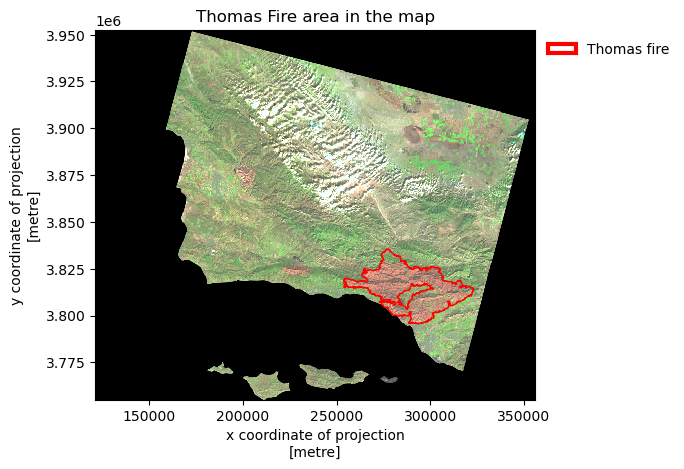

In [12]:
fig, ax = plt.subplots()

# bring the clipping map
fire_districts_clip[['swir22','nir08','red']].to_array().plot.imshow(robust = True)


# bring the fire thomas map
fire_thomas.plot(ax=ax, edgecolor='red', color='none')
# create the patch
fire_thomas_patch = mpatches.Patch(edgecolor='red', facecolor='none', linewidth=3,
                              label='Thomas fire')
 

# Adding legend with custom label colors and settings
legend = ax.legend(handles=[fire_thomas_patch], frameon=False,loc='upper left', bbox_to_anchor= (1, 1))
ax.set_title('Thomas Fire area in the map')

plt.show()